# Adam Research Linear Solvers 

In [19]:
using LinearAlgebra
using SparseArrays
using DelimitedFiles
using IterativeSolvers
using Preconditioners
using Plots 

## Section 1: Introduction 
More later. 

## Section 2: Read Data Files from Disk and Convert to Linear System   

### Read RHS vector of size 7103 
Skip over first line to skip size information.

In [20]:
file = open("B.dat", "r")
b = readdlm(file, Float64, skipstart=1); 

### Read sparse coefficient matrix of size 7103-by-7103 and 44355 non-zero elements from file 
1. ia is one element longer than problem size. This is because ia[end] - ia[end-1] holds the number of non-zeros of the last row of the coefficient matrix. Read by skipping over one line of row information;
1. ja is an integer vector of size 44355. ja contains the column index of the non-zero entries; 
1. a is a float vector of size 44355. a contains matrix entries. 

In [21]:
n = 7103 
file = open("ia.dat", "r")
ia = readdlm(file, Int64, skipstart=1); 
ia = reduce(vcat,ia)
file = open("ja.dat", "r")
ja = readdlm(file, Int64, skipstart=1); 
ja = reduce(vcat,ja)
file = open("A.dat", "r")
a = readdlm(file, Float64, skipstart=1)
a = reduce(vcat,a);

In [22]:
A = SparseMatrixCSC(n,n,ia,ja,a)

7103×7103 SparseMatrixCSC{Float64, Int64} with 44355 stored entries:
⎡⠻⣦⡈⠀⠈⠉⠉⠁⠀⠀⠀⠀⠀⠘⢦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎤
⎢⠂⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⡆⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠇⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⣀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⢆⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢦⡀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⎥
⎣⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⎦

### Read Solution vector (for verification purposes) of size 7103 
Again, skip over first line to skip size information.

In [23]:
file = open("X.dat", "r")
x = readdlm(file, Float64, skipstart=1); 

## Section 3: Solve by sparse direct method 
Do not recover the reference solution. Issue with scaling or boundary conditions. 

In [24]:
myx = A \ b

7103×1 Matrix{Float64}:
 1.609350373641022e-5
 1.609759074595404e-5
 1.6104230636046218e-5
 1.6572965332887793e-5
 1.6571367875810626e-5
 1.6573952247652233e-5
 1.6572427907009742e-5
 1.6235447973061156e-5
 1.6238617237537282e-5
 1.624418199461355e-5
 1.6576679974280646e-5
 1.6576023155036176e-5
 1.6580272294414088e-5
 ⋮
 3.0033829434505285e-7
 3.004779493612513e-7
 3.0061192756879103e-7
 3.0075466227768267e-7
 3.009226131365465e-7
 3.011353773207696e-7
 3.014171281235321e-7
 3.0179570158989866e-7
 3.022929274348417e-7
 3.0288900887783957e-7
 3.034328642820852e-7
 3.0355428535942326e-7

In [25]:
x ./ myx

7103×1 Matrix{Float64}:
 2.39049237778038e6
 2.3902948838946684e6
 2.3898173894958026e6
 4.9299293773174435e6
 4.939051604434922e6
 4.923793629874082e6
 4.932766510491893e6
 2.1737123792383247e6
 2.1737069845332424e6
 2.1734988379356707e6
 4.903859705836597e6
 4.905977436270511e6
 4.876365792821687e6
 ⋮
 1.0380052708365831e8
 1.036007392045291e8
 1.0345539146873803e8
 1.033481419121836e8
 1.0326669186562625e8
 1.0320269887213455e8
 1.0315083795448035e8
 1.0310789504516332e8
 1.0307207723034275e8
 1.0304296741560197e8
 1.0301891028133456e8
 1.0299665207884121e8

## Section 4: Solve by iterative method 

In [26]:
prec  = AMGPreconditioner{RugeStuben}(A)
u, ch = cg(A, b, Pl=prec, maxiter=100000, log=true)

display(ch)

Not converged after 100000 iterations.

In [32]:
invec = ones(7103) 
outvec = A*invec

7103-element Vector{Float64}:
 -2.805527013362979e8
 -2.8055270133629787e8
 -2.805527013362979e8
 -2.1731384330796272e8
 -2.1731384330796272e8
 -2.1731384330796266e8
 -2.1731384330796266e8
 -2.8055329722348e8
 -2.8055329722348e8
 -2.8055329722348e8
 -2.1731384330796266e8
 -2.1731384330796266e8
 -2.1731384330796272e8
  ⋮
  4.029035759975194e7
  4.029035759975194e7
  4.029035759975194e7
  4.029035759975194e7
  4.029035759975194e7
  4.029035759975194e7
  4.029035759975194e7
  4.029035759975194e7
  4.029035759975194e7
  4.029035759975194e7
  4.029035759975194e7
  4.0290357599752e7

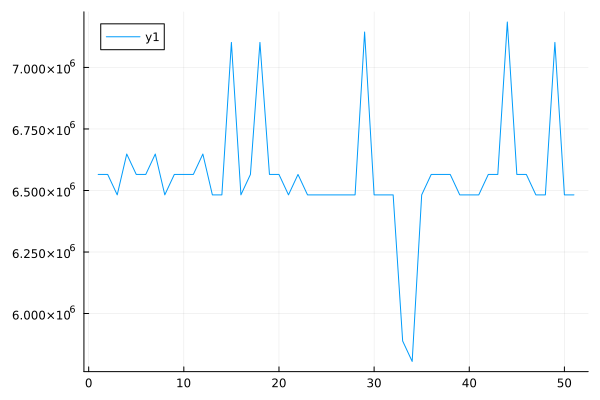

In [30]:
ddd = [A[i,i] for i=3000:3050]; 
plot(ddd)